# Generate queries

This notebook outlines the steps undertook to generate the queries to serve as datapoints to create query-result pairs for modeling & evaluation under the IR task formation.

# Import libraries

In [1]:
#%pip install tiktoken -q
#%pip install openai -q

import time
import json

import numpy as np
import pandas as pd

import tiktoken
from openai import OpenAI

# Global variables

In [2]:
API_KEY = "YOUR_API_KEY"
SYSTEM_PROMPT = '''
Given a list of case law opinions, generate two search queries for each opinion. 
The 'relevant' search query should satisfy that the opinion is relevant for the query and satisfy all the query specifications, 
while the 'irrelevant' search query should be not relevant to the opinion. Return the queries in a form of a json. 
Here is an example: 
input = {'id 1': 'opinion 1', 
         'id 2': 'opinion 2', 
         'id 3': 'opinion 3'}, 
output = {'id 1': {'relevant': 'relevant 1', 'irrelevant': 'irrelevant 1'}, 
          'id 2': {'relevant': 'relevant 2', 'irrelevant': 'irrelevant 2'},
          'id 3': {'relevant': 'relevant 3', 'irrelevant': 'irrelevant 3'}}
'''

# Helper functions

In [3]:
# from openai cookbook: https://cookbook.openai.com/examples/how_to_count_tokens_with_tiktoken
def num_tokens_from_messages(system_prompt, user_prompt, model="gpt-4o-mini-2024-07-18"):
    """Return the number of tokens used by a list of messages."""

    messages = [{"role": "system", "content": f"{system_prompt}"},
                {"role": "user", "content": f"{user_prompt}"}]
    
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using o200k_base encoding.")
        encoding = tiktoken.get_encoding("o200k_base")
    if model in {
        "gpt-3.5-turbo-0125",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
        "gpt-4o-mini-2024-07-18",
        "gpt-4o-2024-08-06"
        }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif "gpt-3.5-turbo" in model:
        print("Warning: gpt-3.5-turbo may update over time. Returning num tokens assuming gpt-3.5-turbo-0125.")
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0125")
    elif "gpt-4o-mini" in model:
        print("Warning: gpt-4o-mini may update over time. Returning num tokens assuming gpt-4o-mini-2024-07-18.")
        return num_tokens_from_messages(messages, model="gpt-4o-mini-2024-07-18")
    elif "gpt-4o" in model:
        print("Warning: gpt-4o and gpt-4o-mini may update over time. Returning num tokens assuming gpt-4o-2024-08-06.")
        return num_tokens_from_messages(messages, model="gpt-4o-2024-08-06")
    elif "gpt-4" in model:
        print("Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613.")
        return num_tokens_from_messages(messages, model="gpt-4-0613")
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

In [4]:
f"number of tokens used by system prompt: {num_tokens_from_messages(' '.join(SYSTEM_PROMPT.split()), '')}"

'number of tokens used by system prompt: 194'

In [25]:
def group_opinions_by_tokens(df, 
                             system_prompt='',
                             max_tokens=40000,
                             max_size=6):
    batches = {} 
    current_batch = []
    current_batch_ids = []
    current_token_count = 0

    for opinion_id, opinion in zip(df["opinion_id"], df["opinion"]): 
        new_batch = current_batch + [opinion]  # Add new opinion to batch
        tokens = num_tokens_from_messages(system_prompt, new_batch)

        # If adding this opinion exceeds max_tokens or max_size, start a new batch
        if tokens > max_tokens or len(new_batch) > max_size:
            if current_batch:  # Avoid adding empty batch
                batches[tuple(current_batch_ids)] = [current_batch, current_token_count]
            # Start new batch with the current opinion
            current_batch = [opinion]  
            current_batch_ids = [opinion_id]
            current_token_count = num_tokens_from_messages(system_prompt, current_batch)

        else:
            current_batch.append(opinion)
            current_batch_ids.append(opinion_id)
            current_token_count = tokens

    # Append the last batch if it contains any opinions
    if current_batch:
        current_token_count = num_tokens_from_messages(system_prompt, current_batch)
        batches[tuple(current_batch_ids)] = [current_batch, current_token_count]

    return batches

In [6]:
def gpt_completion(api_key,
                   system_prompt,
                   user_prompt, 
                   model="gpt-4o-mini"):
    
    client = OpenAI(api_key=api_key)
    completion = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=[{"role": "system", "content": f"{system_prompt}"},
                  {"role": "user","content": f"{user_prompt}"}]
    )
    
    result = completion.choices[0].message.content
    return result

# Load the data

In [7]:
df = pd.read_csv("outputs/1b.opinions_cleaned.csv")
df = df[["opinion_id", "opinion"]]
df.head()

,opinion_id,opinion
0,444587,"748 F.2d 972 UNITED STATES of America, Plainti..."
1,9410469,Nebraska Supreme Court Online Library www.nebr...
2,714663,78 F.3d 599 U.S. v. Johnston ** NO. 94-2273 Un...
3,2729050,"Pursuant to Ind. Appellate Rule 65(D), this Me..."
4,692963,51 F.3d 288 311 U.S.App.D.C. 145 UNITED STATES...


# Count the number of gpt-4o-mini tokens for each opinion

In [8]:
df['opinion_4omini_tokens'] = df["opinion"].apply(lambda x: num_tokens_from_messages("", x))
df['opinion_4omini_tokens'].describe()

count      953.000000
mean      2235.194124
std       3089.424231
min         14.000000
25%        216.000000
50%       1209.000000
75%       2941.000000
max      30190.000000
Name: opinion_4omini_tokens, dtype: float64

<Axes: >

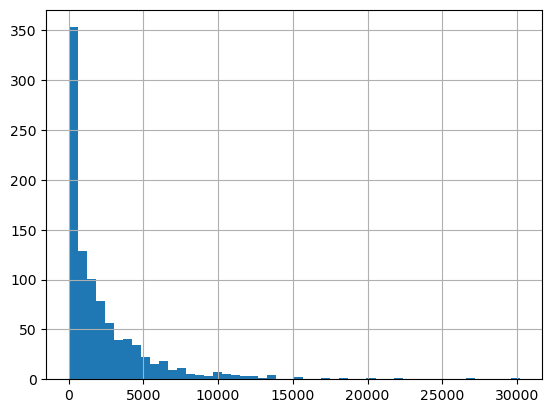

In [9]:
df['opinion_4omini_tokens'].hist(bins=50)

# Generate batches for API requests

This section is really messy because I had to experiment with the prompt, batch size, number of tokens, and I got rate limited on the free tier... To avoid wasting the responses generated during experimentation, I ran the below code blocks iteratively in small batches until all the data was processed. If you are not worried about usage limits and managing cost, you can ignore the df manipulations and directly run through all batches.

Generating both relevant and irrelevant queries used ~1.8M input tokens and 24K outputs, which translates to ~\$0.3 (+0.15/1000000\*1800000 + 0.6/1000000*24000) with the 4o-mini model. 

When signing up for a new OpenAI account with API access, you are granted a \\$5 starting credit for free. However, to get over the Free tier rate limit, you need to upgrade the account by linking a credit card and add \$5 to the account. (FYI, the Free tier rate limit on the OpenAI website is bogus, I spent HOURS designing and experimenting with batch size and wait time in an attempt to "cleverly" be under the rate limit, but was rate limited within 5 batches of requests, even though the requests were way below the TPM and RPD limits. This is all to say, don't be like me if you want to use OpenAI API to do cool stuff).

In [135]:
todo = df[df["relevant_query_stmt"].isna()]
len(todo)

119

In [138]:
batches = group_opinions_by_tokens(todo, max_tokens=60000, max_size=6)
len(batches.keys())

20

In [139]:
for ids, [opinions, num_tokens] in batches.items():
    print(ids)
    print(num_tokens)

(3210325, 1505662, 5353026, 5363734, 5364874, 5364935)
8766
(5372695, 5409063, 5415284, 5430564, 5439545, 5458786)
8746
(5462915, 5467874, 5488236, 5490555, 3836669, 5513206)
4062
(5526828, 5530509, 5536698, 5537070, 5537188, 5540741)
6303
(5582360, 5585375, 5595665, 5624603, 5634795, 5638976)
2702
(5646724, 5652865, 5658078, 5665858, 5671539, 5671863)
12220
(5686161, 5691029, 5694442, 5698910, 5702250, 5711705)
7823
(5715008, 5720288, 5737027, 5737195, 3544741, 5748852)
3490
(5759944, 5777043, 5854417, 5856723, 5857491, 5868217)
3576
(5896737, 5902832, 5903097, 1123999, 5919424, 5958351)
5547
(5972065, 5973290, 5986493, 5983229, 5990572, 6021612)
2736
(6049073, 6062110, 750306, 6085891, 456313, 6086760)
5707
(6090211, 6091771, 6071605, 6100808, 6102151, 6137122)
1851
(6155711, 6190312, 6198051, 6199131, 6200542, 6211579)
13230
(6212018, 6219475, 9560674, 6228332, 6230427, 6232199)
5149
(1554420, 6237195, 6237262, 6238905, 6173548, 6180733)
6382
(6310436, 6311699, 6254514, 6267182, 628

In [140]:
%%time

counter = 1
results = {}
errors = {}
for ids, [opinions, num_tokens] in batches.items():
    print(f"batch {counter} started...")
    
    try:
        result = gpt_completion(API_KEY, ' '.join(SYSTEM_PROMPT.split()), {ids[i]: opinions[i] for i in range(len(ids))})
        try:
            loaded_result = json.loads(result)
        except:
            loaded_result = result
        
        results[ids] = {
            "opinions": opinions,
            "num_tokens": num_tokens,
            "result": loaded_result
        }
        print(f"batch {counter} completed...")
    except Exception as e:
        errors[ids] = f"{e}"
        print(f"batch {counter} {e}...")
    
    counter += 1
    time.sleep(30)

batch 1 started...
batch 1 completed...
batch 2 started...
batch 2 completed...
batch 3 started...
batch 3 completed...
batch 4 started...
batch 4 completed...
batch 5 started...
batch 5 completed...
batch 6 started...
batch 6 completed...
batch 7 started...
batch 7 completed...
batch 8 started...
batch 8 completed...
batch 9 started...
batch 9 completed...
batch 10 started...
batch 10 completed...
batch 11 started...
batch 11 completed...
batch 12 started...
batch 12 completed...
batch 13 started...
batch 13 completed...
batch 14 started...
batch 14 completed...
batch 15 started...
batch 15 completed...
batch 16 started...
batch 16 completed...
batch 17 started...
batch 17 completed...
batch 18 started...
batch 18 completed...
batch 19 started...
batch 19 completed...
batch 20 started...
batch 20 completed...
CPU times: user 1.16 s, sys: 363 ms, total: 1.52 s
Wall time: 11min 59s


In [141]:
rows = []
issues = []
for ids, values in results.items():
    opinions = values['opinions']
    result = values['result']
    
    for opinion, id_ in zip(opinions, ids):
        try:
            rows.append({
                'opinion_id': id_,
                'input_opinion': opinion,
                'relevant_query_stmt': result[str(id_)]['relevant'],
                'irrelevant_query_stmt': result[str(id_)]['irrelevant']
            })
        except:
            issues.append(ids)

In [142]:
results_df = pd.DataFrame(rows)
results_df

,opinion_id,input_opinion,relevant_query_stmt,irrelevant_query_stmt
0,3210325,Citation Nr: 1617320 Decision Date: 04/29/16 A...,service connection heart disease veterans bene...,heart disease legal advice
1,1505662,865 F. Supp. 1180 (1993) The AMERICAN ANGUS AS...,trademark cancellation certification mark stan...,real estate property disputes
2,5353026,"Order unanimously affirmed, with twenty dolla...",court judgment appeal costs,bankruptcy filings
3,5363734,"Judgment by a city magistrate, sitting as a C...",public traffic violation section 2147,private contract disputes
4,5364874,Motion for reargument denied. Motion for leav...,reargument leave to appeal,disputes over rental agreements
...,...,...,...,...
114,524265,"876 F.2d 266 1989-1 Trade Cases 68,591 , 16 Me...",New York Times antitrust case against independ...,Effect of social media on newspaper readership...
115,839254,750 N.W.2d 177 (2008) PEOPLE of the State of M...,Michigan Supreme Court denial of leave to appe...,Federal regulations on immigration reform
116,563586,936 F.2d 585 U.S. v. Rodriguez * NO. 90-3023 U...,Appeal outcome in United States v. Rodriguez r...,Landmark Supreme Court decisions on privacy ri...
117,9607832,"SHEPARD, J., concurs in the result. BAKES, Ju...",Due process concerns in a civil trial regardin...,Economic impact of environmental regulations o...


In [143]:
df = df.merge(results_df, how="left", on="opinion_id", suffixes=('', '_results'))

# Replace NaN values in df with corresponding values from results_df
for column in results_df.columns:
    if column != "opinion_id": 
        df[column] = df[column].fillna(df[column + '_results'])
        df.drop(columns=[column + '_results'], inplace=True)

In [144]:
done = df[~df["relevant_query_stmt"].isna()]
len(done)

953

# Save the resulting df with generated queries

In [147]:
df.to_csv("outputs/2a.queries_generated.csv", index=False)